In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet
import pmdarima as pm


Pulling in Data from KU_Pandas_for_database for a trial run of the Machine Learning Model

In [14]:
import yfinance as yf
df_occidental = yf.download('OXY', start='2019-01-01', end='2022-01-01', progress=False)

df_occidental.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,60.520000,62.400002,59.720001,62.000000,55.900429,5355300
2019-01-03,62.180000,62.400002,60.730000,61.240002,55.215210,5465500
2019-01-04,62.279999,63.419998,62.029999,63.209999,56.991394,6367400
2019-01-07,63.549999,65.330002,62.750000,64.480003,58.136440,5771600
2019-01-08,65.300003,66.309998,64.900002,64.989998,58.596283,5420100


In [15]:
df_sp = yf.download('^GSPC', start='2019-01-01', end='2022-01-01', progress=False)

Plotting Closing Price to visualize 

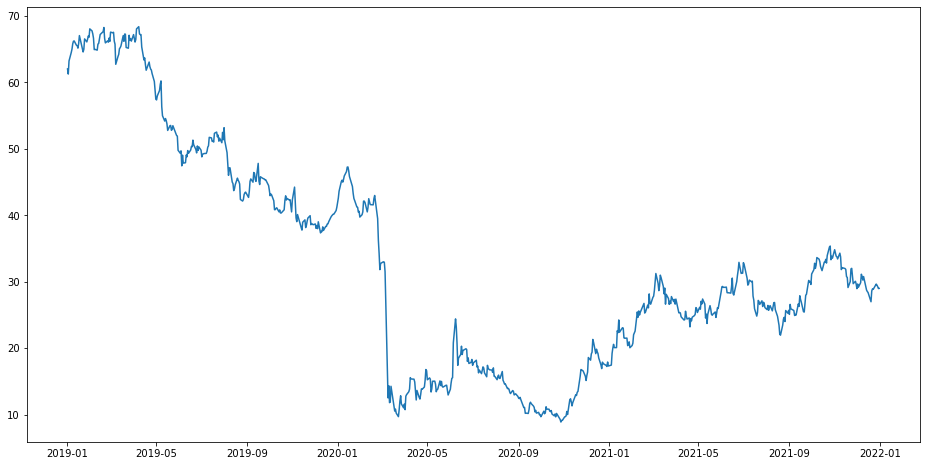

In [16]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df_occidental['Close'], label='Close Price History')

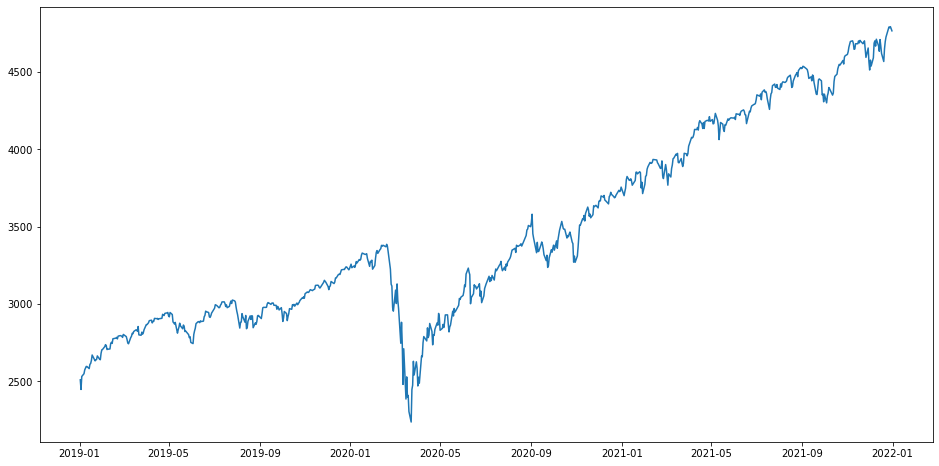

In [17]:
plt.figure(figsize=(16,8))
plt.plot(df_sp['Close'], label='Close Price History')

Looking at the Distribution of the Dataset

<AxesSubplot:ylabel='Density'>

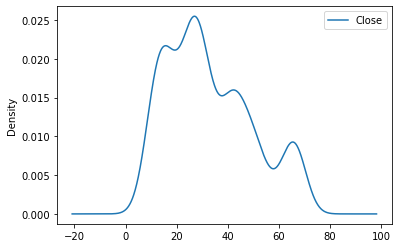

In [18]:
df_occidental_close = df_occidental[['Close']]
df_occidental_close.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

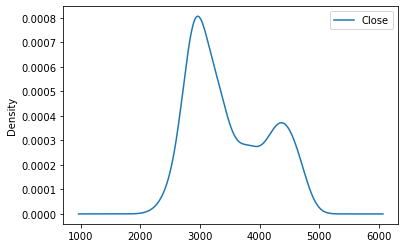

In [19]:
df_sp_close = df_sp[['Close']]
df_sp_close.plot(kind='kde')

Splitting Data into Train and Test DataSet into 80% Training Data and 20% Testing Data

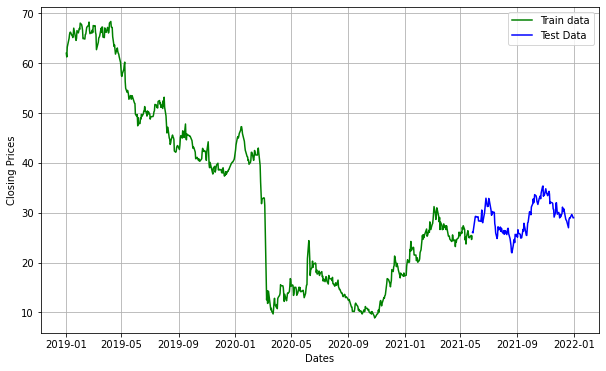

In [20]:
occidental_train_data= df_occidental_close.iloc[:int(df_occidental_close.shape[0]*0.8)]
occidental_test_data = df_occidental_close.iloc[int(df_occidental_close.shape[0]*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(occidental_train_data, 'Green', label='Train data')
plt.plot(occidental_test_data, 'blue',  label='Test Data')
plt.legend()

This Machine Learning Model will run a linear regression, ARIMA model, and a Facebook Prophet model
- limitations of these models will be they do not take into account current world situations (like COVID impacts on economy)

Linear Regression Model

In [21]:
df_linear_occidental = pd.merge(df_occidental_close, df_sp_close, on='Date')
df_linear_occidental = df_linear_occidental.rename(columns={'Close_x': 'Occidental Close', 'Close_y':'S&P Close'})

In [22]:
# for linear regression model we need an x_train value, and a y_train value
X_train, X_test, y_train, y_test = train_test_split(df_linear_occidental[['Occidental Close']], df_linear_occidental[['S&P Close']], test_size=.2)

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = linear_regression_model.predict(X_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [25]:
print('Mean Absolute Error:', mae)
print('Coefficient of Determination:', r2)
print('Mean Squared Error:', mse)

Mean Absolute Error: 510.65935018734234
Coefficient of Determination: 0.10096735826595826
Mean Squared Error: 383901.82107913034


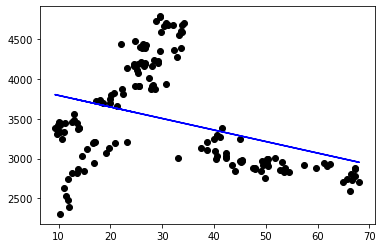

In [26]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue')
plt.show()

Arima Model

In [27]:
# ARIMA Model
arima_model = pm.auto_arima(occidental_train_data, d=1, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=6, max_order=None , trace=True)

arima_model.fit(occidental_train_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1888.885, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1890.123, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1888.960, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1889.261, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1889.799, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1890.927, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1891.328, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1890.369, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1890.395, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1890.334, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1892.334, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1892.492, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1888.435, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [28]:
arima_y_pred = occidental_test_data.copy()

# Forecasting the Data
prediction_arima = arima_model.predict(len(occidental_test_data))
arima_y_pred["ARIMA Model Prediction"]=prediction_arima

In [29]:
r2_arima = r2_score(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mae_arima = mean_absolute_error(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mse_arima = mean_squared_error(arima_y_pred['Close'], arima_y_pred["ARIMA Model Prediction"])

print('Mean Absolute Error for ARIMA Model:', mae_arima)
print('Coefficient of Determination for ARIMA Model:', r2_arima)
print('Mean Squared Error for ARIMA Model:', mse_arima)

Mean Absolute Error for ARIMA Model: 3.9675187866170543
Coefficient of Determination for ARIMA Model: -1.576524944301822
Mean Squared Error for ARIMA Model: 22.858645110539207


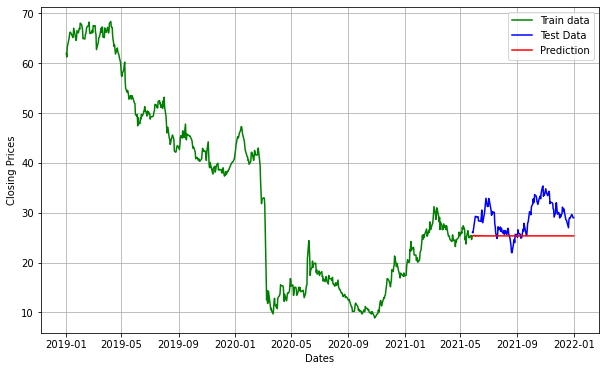

In [30]:
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(occidental_train_data, 'Green', label='Train data')
plt.plot(occidental_test_data, 'blue',  label='Test Data')
plt.plot(arima_y_pred["ARIMA Model Prediction"], 'Red', label='Prediction')
plt.legend()


Facebook Prophet Model with Plot of Actual vs Predictions

In [31]:
# Facebook Prophet Model
prophet_data = df_occidental_close.copy()
prophet_data = prophet_data.reset_index()

#preparing data
prophet_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
prophet_train = prophet_data[:int(prophet_data.shape[0]*0.80)]
prophet_test = prophet_data[int(prophet_data.shape[0]*0.80):]

#fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

#predictions
close_prices = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.3445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1379.87     0.0138235       111.317           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1398.28     0.0807579       162.997           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       1402.66    0.00110816       423.566   2.933e-06       0.001      298  LS failed, Hessian reset 
     299       1406.32      0.121298       189.057      0.9323           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       1406.55     0.0024128       138.057   1.276e-05       0.001      427  LS failed, Hessian reset 
     367       1407.87   0.000461649       173.395   5.912e-06       0.001      553  LS failed, Hessian rese

In [32]:
forecast = forecast.set_index('ds')
forecast = forecast.rename(columns={'yhat':'Prediction'})

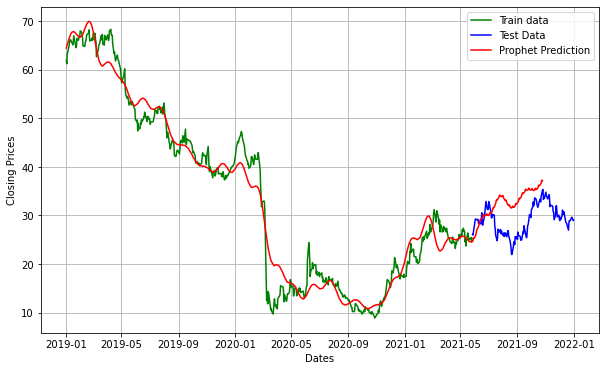

In [33]:
# Facebook Prophet Models
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(occidental_train_data, 'Green', label='Train data')
plt.plot(occidental_test_data, 'blue',  label='Test Data')
plt.plot(forecast['Prediction'], 'Red', label='Prophet Prediction')
plt.legend()


#Will need to update model so it predicts full test data


In [34]:
# Get Statistics for Prophet Predictions